In [10]:
from trackml.dataset import load_event, load_dataset
from trackml.score import score_event
from sklearn import preprocessing
import pandas as pd
import numpy as np
import glob, hdbscan

import operator

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse.csgraph import connected_components

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
%matplotlib inline

In [11]:
# inspired by https://www.kaggle.com/asalzburger/pixel-detector-cells
# by Andreas Salzburger


from math import degrees

print()

# h stands for hits

def add_p_phi_theta_truth(h, truth):
    truth = truth.apply(abs)
    truth['tpr'] = np.sqrt(truth.tpx ** 2 + truth.tpy ** 2)
    truth['p_phi_truth'] = np.arctan2(truth.tpy, truth.tpx)
    truth['p_theta_truth'] = np.arctan2(truth.tpr, truth.tpz)
    return h.merge(truth[['hit_id', 'p_phi_truth', 'p_theta_truth']],
                   on='hit_id', how='left')

def add_cells(h, cells):
    h_clusters = cells.groupby('hit_id') \
                      .agg({'ch0': ['min', 'max'],
                            'ch1': ['min', 'max']}) \
                      .reset_index()
    h_clusters.columns = ['_'.join(column).strip('_')
                          for column in h_clusters.columns.values]
    return h.merge(h_clusters, on='hit_id', how='left')

def add_detectors(h, detectors):
    return h.merge(detectors,
                   on=['volume_id', 'layer_id', 'module_id'], how='left')

def add_p_phi_theta_simplistic(h):
    h['cluster_size_u'] = h.ch0_max - h.ch0_min
    h['cluster_size_v'] = h.ch1_max - h.ch1_min
    # i think in general it should be 0.5 below, 
    # but other values like 0. or 0.2 might give better results
    # h.loc[h.cluster_size_u == 0, 'cluster_size_u'] = 0.2
    # h.loc[h.cluster_size_v == 0, 'cluster_size_v'] = 0.2

    h['pu'] = h.cluster_size_u * h.pitch_u
    h['pv'] = h.cluster_size_v * h.pitch_v
    h['pw'] = 2 * h.module_t
    h['px'] = abs(h.rot_xu * h.pu + h.rot_xv * h.pv + h.rot_xw * h.pw)
    h['py'] = abs(h.rot_yu * h.pu + h.rot_yv * h.pv + h.rot_yw * h.pw)
    h['pz'] = abs(h.rot_zu * h.pu + h.rot_zv * h.pv + h.rot_zw * h.pw)
    h['pr'] = np.sqrt(h.px ** 2 + h.py ** 2)
    h['p_phi'] = np.arctan2(h.py, h.px)
    h['p_theta'] = np.arctan2(h.pr, h.pz)
    
def add_p_phi_theta(h):
    h['cluster_size_u_max'] = h.ch0_max - h.ch0_min + 1
    h['cluster_size_u_min'] = h.cluster_size_u_max - 2
    h.loc[h.cluster_size_u_min < 0, 'cluster_size_u_min'] = 0

    h['cluster_size_v_max'] = h.ch1_max - h.ch1_min + 1
    h['cluster_size_v_min'] = h.cluster_size_v_max - 2
    h.loc[h.cluster_size_v_min < 0, 'cluster_size_v_min'] = 0

    h['pu_max'] = h.cluster_size_u_max * h.pitch_u
    h['pu_min'] = h.cluster_size_u_min * h.pitch_u

    h['pv_max'] = h.cluster_size_v_max * h.pitch_v
    h['pv_min'] = h.cluster_size_v_min * h.pitch_v

    h['pw'] = 2 * h.module_t

    h['angle_u_max'] = np.arctan2(h.pu_max, h.pw)
    h['angle_u_min'] = np.arctan2(h.pu_min, h.pw)
    h['angle_u_avg'] = 0.5 * (h.angle_u_max + h.angle_u_min)
    h['pu'] = h.pw * np.tan(h.angle_u_avg)

    h['angle_v_max'] = np.arctan2(h.pv_max, h.pw)
    h['angle_v_min'] = np.arctan2(h.pv_min, h.pw)
    h['angle_v_avg'] = 0.5 * (h.angle_v_max + h.angle_v_min)
    h['pv'] = h.pw * np.tan(h.angle_v_avg)

    h['px'] = abs(h.rot_xu * h.pu + h.rot_xv * h.pv + h.rot_xw * h.pw)
    h['py'] = abs(h.rot_yu * h.pu + h.rot_yv * h.pv + h.rot_yw * h.pw)
    h['pz'] = abs(h.rot_zu * h.pu + h.rot_zv * h.pv + h.rot_zw * h.pw)
    h['pr'] = np.sqrt(h.px ** 2 + h.py ** 2)
    h['p_phi'] = np.arctan2(h.py, h.px)
    h['p_theta'] = np.arctan2(h.pr, h.pz)

def info_errors(h):
    h['error_p_phi'] = abs(h.p_phi - h.p_phi_truth)
    h['error_p_theta'] = abs(h.p_theta - h.p_theta_truth)

    print(degrees(h.error_p_phi.mean()), degrees(h.error_p_phi.std()))
    print(degrees(h.error_p_theta.mean()), degrees(h.error_p_theta.std()))

def info_angles(h):
    print(degrees(h.p_phi.min()), degrees(h.p_phi.max()))
    print(degrees(h.p_theta.min()), degrees(h.p_theta.max()))
    print(degrees(h.p_phi_truth.min()), degrees(h.p_phi_truth.max()))
    print(degrees(h.p_theta_truth.min()), degrees(h.p_theta_truth.max()))

def run_sample_event(event_path):
    h, cells, _, truth = load_event(event_path)
    detectors = pd.read_csv('../data/detectors.csv')
    
    h = add_cells(h, cells)
    h = add_detectors(h, detectors)
    add_p_phi_theta(h)

    # much lower theta error below
    # h = h.loc[h.volume_id <= 9].copy()

    h = add_p_phi_theta_truth(h, truth)
    info_errors(h)
    
    info_angles(h)

run_sample_event('../data/train_100_events/event000001000')


19.527994260255614 16.19124320003879
9.993242849871265 10.081615241336488
0.025507314031954612 89.99721926419038
5.019440465954389 88.01655856071082
0.0006754992055603151 89.9999273723973
0.001847667889614272 89.99875257986005


In [12]:
scl = preprocessing.StandardScaler()

#https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
#https://www.kaggle.com/mikhailhushchyn/hough-transform
def norm_points(df):
    x = df.x.values
    y = df.y.values
    z = df.z.values
    r = np.sqrt(x**2 + y**2 + z**2)
    df['x2'] = x/r
    df['y2'] = y/r
    df['z2'] = z / np.sqrt(x**2 + y**2)
        
    return df

In [13]:
h, cells, particles, truth = load_event('../data/train_100_events/event000001000')
detectors = pd.read_csv('../data/detectors.csv')

h = add_cells(h, cells)
h = add_detectors(h, detectors)
add_p_phi_theta(h)

# much lower theta error below
# h = h.loc[h.volume_id <= 9].copy()

h = add_p_phi_theta_truth(h, truth)
info_errors(h)

info_angles(h)

19.527994260255614 16.19124320003879
9.993242849871265 10.081615241336488
0.025507314031954612 89.99721926419038
5.019440465954389 88.01655856071082
0.0006754992055603151 89.9999273723973
0.001847667889614272 89.99875257986005


In [14]:
h.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,ch0_min,ch0_max,ch1_min,ch1_max,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,rot_yv,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v,cluster_size_u_max,cluster_size_u_min,cluster_size_v_max,cluster_size_v_min,pu_max,pu_min,pv_max,pv_min,pw,angle_u_max,angle_u_min,angle_u_avg,pu,angle_v_max,angle_v_min,angle_v_avg,pv,px,py,pz,pr,p_phi,p_theta,p_phi_truth,p_theta_truth,error_p_phi,error_p_theta
0,1,-64.409897,-7.163700,-1502.5,7,2,1,209,210,617,618,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,2,0,2,0,0.10,0.00,0.11250,0.000,0.3,0.321751,0.000000,0.160875,0.048683,0.358771,0.000000,0.179385,0.054400,0.050413,0.052801,0.3,0.073003,0.808534,0.238704,0.538899,0.296432,0.269635,0.057727
1,2,-55.336102,0.635342,-1502.5,7,2,1,68,68,446,446,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.00,0.05625,0.000,0.3,0.165149,0.000000,0.082574,0.024829,0.185348,0.000000,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,0.049714,0.036861,0.756363,0.086952
2,3,-83.830498,-1.143010,-1502.5,7,2,1,58,60,951,956,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,3,1,6,4,0.15,0.05,0.33750,0.225,0.3,0.463648,0.165149,0.314398,0.097555,0.844154,0.643501,0.743828,0.276040,0.267535,0.118912,0.3,0.292771,0.418249,0.773204,0.264705,0.706133,0.153544,0.067071
3,4,-96.109100,-8.241030,-1502.5,7,2,1,181,181,1181,1181,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.00,0.05625,0.000,0.3,0.165149,0.000000,0.082574,0.024829,0.185348,0.000000,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,0.222542,0.062294,0.583535,0.061519
4,5,-62.673599,-9.371200,-1502.5,7,2,1,256,256,590,590,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.00,0.05625,0.000,0.3,0.165149,0.000000,0.082574,0.024829,0.185348,0.000000,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,0.083152,0.042994,0.722925,0.080818


In [15]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [16]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [33]:
norm_points(h)
hits  = h

hits['r'] = np.sqrt(hits['x']**2 + hits['y']**2)
m = 'euclidean'
dbscan = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7, cluster_selection_method='leaf', prediction_data=False, metric=m)

hits['x3'] = hits['x2'] + hits['pr']
hits['y3'] = hits['y2'] + hits['pr']
hits['z3'] = hits['z2'] + hits['pr']
# labels= dbscan.fit_predict(scl.fit_transform(hits[['z2', 'phi', 'rho', 'r', 'theta', 'tan_dip']].values))
labels= dbscan.fit_predict(scl.fit_transform(hits[['x3', 'y3', 'z3']].values))
hits['track_id'] = labels+1
hits['event_id'] = 1000
score = score_event(truth, hits[['event_id','hit_id','track_id']])
print(m, len(truth['particle_id'].unique()), len(hits['track_id'].unique()), score)

euclidean 10566 7272 0.09198276589557514


In [36]:
hits = hits.merge(truth, on='hit_id', how='left')

In [37]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,ch0_min,ch0_max,ch1_min,ch1_max,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,rot_yv,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v,cluster_size_u_max,cluster_size_u_min,cluster_size_v_max,cluster_size_v_min,pu_max,pu_min,pv_max,pv_min,pw,angle_u_max,angle_u_min,angle_u_avg,pu,angle_v_max,angle_v_min,angle_v_avg,pv,px,py,pz,pr,p_phi,p_theta,p_phi_truth,p_theta_truth,error_p_phi,error_p_theta,x2,y2,z2,x3,y3,z3,track_id,event_id,r,lambda,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,-64.409897,-7.163700,-1502.5,7,2,1,209,210,617,618,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,2,0,2,0,0.10,0.00,0.11250,0.000,0.3,0.321751,0.000000,0.160875,0.048683,0.358771,0.000000,0.179385,0.054400,0.050413,0.052801,0.3,0.073003,0.808534,0.238704,0.538899,0.296432,0.269635,0.057727,-0.042829,-0.004763,-23.184208,0.030174,0.068240,-23.111205,0,1000,64.807045,-23.184208,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,-55.336102,0.635342,-1502.5,7,2,1,68,68,446,446,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.00,0.05625,0.000,0.3,0.165149,0.000000,0.082574,0.024829,0.185348,0.000000,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,0.049714,0.036861,0.756363,0.086952,-0.036804,0.000423,-27.150467,0.000530,0.037757,-27.113132,1233,1000,55.339748,-27.150467,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,-83.830498,-1.143010,-1502.5,7,2,1,58,60,951,956,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,3,1,6,4,0.15,0.05,0.33750,0.225,0.3,0.463648,0.165149,0.314398,0.097555,0.844154,0.643501,0.743828,0.276040,0.267535,0.118912,0.3,0.292771,0.418249,0.773204,0.264705,0.706133,0.153544,0.067071,-0.055707,-0.000760,-17.921406,0.237064,0.292012,-17.628635,42,1000,83.838287,-17.921406,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,181,181,1181,1181,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.00,0.05625,0.000,0.3,0.165149,0.000000,0.082574,0.024829,0.185348,0.000000,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,0.222542,0.062294,0.583535,0.061519,-0.063835,-0.005474,-15.576118,-0.026500,0.031861,-15.538783,2999,1000,96.461777,-15.576118,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,-62.673599,-9.371200,-1502.5,7,2,1,256,256,590,590,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,1,0,1,0,0.05,0.00,0.05625,0.000,0.3,0.165149,0.000000,0.082574,0.024829,0.185348,0.000000,0.092674,0.027882,0.025848,0.026940,0.3,0.037335,0.806077,0.123812,0.083152,0.042994,0.722925,0.080818,-0.041676,-0.006232,-23.709833,-0.004341,0.031103,-23.672499,2287,1000,63.370335,-23.709833,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [38]:
hits['lambda'] = hits['z']/hits['r']

In [39]:
hits.sort_values(['particle_id', 'hit_id'])[hits['particle_id'] != 0].head(30)

,hit_id,x,y,z,volume_id,layer_id,module_id,ch0_min,ch0_max,ch1_min,ch1_max,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,rot_yv,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v,cluster_size_u_max,cluster_size_u_min,cluster_size_v_max,cluster_size_v_min,pu_max,pu_min,pv_max,pv_min,pw,angle_u_max,angle_u_min,angle_u_avg,pu,angle_v_max,angle_v_min,angle_v_avg,pv,px,py,pz,pr,p_phi,p_theta,p_phi_truth,p_theta_truth,error_p_phi,error_p_theta,x2,y2,z2,x3,y3,z3,track_id,event_id,r,lambda,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
20879,20880,-6.369360,31.603201,-20.085800,8,2,109,168,170,903,906,-6.291660e+00,31.6303,-35.0,-0.943966,0.000000e+00,-0.330043,-3.300430e-01,0.000000,0.943966,0,1,0,0.15,8.4,8.4,36,0.05,0.05625,3,1,4,2,0.15,0.05,0.22500,0.11250,0.3,0.463648,0.165149,0.314398,0.097555,0.643501,0.358771,0.501136,0.164333,0.191102,0.250992,0.164333,0.315463,0.920049,1.090547,1.340371,1.015846,0.420322,0.074701,-0.167686,0.832017,-0.623035,0.147777,1.147481,-0.307571,5132,1000,32.238659,-0.623035,4503668346847232,-6.373050,31.601900,-20.080000,-0.074873,0.319162,-0.203232,0.000018
29322,29323,-16.957899,71.002403,-45.639400,8,4,218,78,79,449,452,-2.097310e+01,69.1389,-35.0,-0.907070,0.000000e+00,-0.420979,-4.209790e-01,0.000000,0.907070,0,1,0,0.15,8.4,8.4,36,0.05,0.05625,2,0,4,2,0.10,0.00,0.22500,0.11250,0.3,0.321751,0.000000,0.160875,0.048683,0.643501,0.358771,0.501136,0.164333,0.170453,0.251626,0.164333,0.303924,0.975397,1.075117,1.270699,1.010978,0.295302,0.064140,-0.196974,0.824725,-0.625202,0.106951,1.128650,-0.321278,5127,1000,72.999397,-0.625202,4503668346847232,-16.962099,71.000504,-45.638100,-0.096428,0.311619,-0.204427,0.000014
35620,35621,-31.189100,112.045998,-73.205704,8,6,302,95,96,1203,1206,-3.443600e+01,110.5090,-105.0,-0.903865,0.000000e+00,-0.427817,-4.278170e-01,0.000000,0.903865,0,1,0,0.15,8.4,8.4,36,0.05,0.05625,2,0,4,2,0.10,0.00,0.22500,0.11250,0.3,0.321751,0.000000,0.160875,0.048683,0.643501,0.358771,0.501136,0.164333,0.172348,0.250332,0.164333,0.303924,0.967845,1.075117,1.197851,1.005003,0.230006,0.070114,-0.226951,0.815314,-0.629424,0.076974,1.119238,-0.325499,5123,1000,116.305916,-0.629424,4503668346847232,-31.188400,112.045998,-73.201897,-0.118230,0.302181,-0.206065,0.000010
42237,42238,-54.560600,162.824997,-108.476997,8,8,453,171,171,576,579,-5.438770e+01,162.9110,-105.0,-0.895067,0.000000e+00,-0.445931,-4.459310e-01,0.000000,0.895067,0,1,0,0.15,8.4,8.4,36,0.05,0.05625,1,0,4,2,0.05,0.00,0.22500,0.11250,0.3,0.165149,0.000000,0.082574,0.024829,0.643501,0.358771,0.501136,0.164333,0.156003,0.257448,0.164333,0.301026,1.026008,1.071097,1.084493,1.009933,0.058485,0.061164,-0.268618,0.801636,-0.631697,0.032408,1.102661,-0.330671,5129,1000,171.723145,-0.631697,4503668346847232,-54.559299,162.826004,-108.474998,-0.151918,0.287370,-0.204184,0.000008
73762,73763,-105.031998,240.365997,-166.699997,13,2,353,363,365,77,78,-1.000720e+02,241.5940,-206.0,-0.970693,0.000000e+00,-0.240323,-2.403230e-01,0.000000,0.970693,0,1,0,0.25,24.0,24.0,54,0.08,1.20000,3,1,2,0,0.24,0.08,2.40000,0.00000,0.5,0.447520,0.158655,0.303088,0.156361,1.365401,0.000000,0.682700,0.406569,0.271940,0.447769,0.406569,0.523879,1.025010,0.910815,0.904323,1.013951,0.120687,0.103136,-0.337941,0.773379,-0.635503,0.185938,1.297258,-0.111624,0,1000,262.311890,-0.635503,4503668346847232,-105.022003,240.369003,-166.449005,-0.200451,0.254855,-0.201860,0.000005
80880,80881,-176.988998,315.605988,-231.559998,13,4,495,327,330,23,24,-1.748640e+02,316.3930,-206.0,-0.937682,0.000000e+00,-0.347495,-3.474950e-01,0.000000,0.937682,0,1,0,0.25,24.0,24.0,54,0.08,1.20000,4,2,2,0,0.32,0.16,2.40000,0.00000,0.5,0.569313,0.309703,0.439508,0.235090,1.365401,0.000000,0.682700,0.406569,0.394187,0.387148,0.406569,0.552510,0.776390,0.936408,0.705699,1.015240,0.070691,0.078832,-0.411990,0.734659,-0.639941,0.140520,1.287169,-0.087431,5468,1000,361.845612,-0.639941,4503668346847232,-177.020004,315.593994,-231.375000,-0.246460,0.210003,-0.201005,0.000005

In [41]:
hits.sort_values(['particle_id', 'hit_id'])[hits['particle_id'] == 0].head(10)

,hit_id,x,y,z,volume_id,layer_id,module_id,ch0_min,ch0_max,ch1_min,ch1_max,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,rot_yv,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v,cluster_size_u_max,cluster_size_u_min,cluster_size_v_max,cluster_size_v_min,pu_max,pu_min,pv_max,pv_min,pw,angle_u_max,angle_u_min,angle_u_avg,pu,angle_v_max,angle_v_min,angle_v_avg,pv,px,py,pz,pr,p_phi,p_theta,p_phi_truth,p_theta_truth,error_p_phi,error_p_theta,x2,y2,z2,x3,y3,z3,track_id,event_id,r,lambda,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,-64.409897,-7.163700,-1502.5,7,2,1,209,210,617,618,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,2,0,2,0,0.10,0.00,0.11250,0.00000,0.3,0.321751,0.000000,0.160875,0.048683,0.358771,0.000000,0.179385,0.054400,0.050413,0.052801,0.3,0.073003,0.808534,0.238704,0.538899,0.296432,0.269635,0.057727,-0.042829,-0.004763,-23.184208,0.030174,0.068240,-23.111205,0,1000,64.807045,-23.184208,0,-64.411598,-7.164120,-1502.5,250710.0,-149908.000000,-956385.0,0.0
2,3,-83.830498,-1.143010,-1502.5,7,2,1,58,60,951,956,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,3,1,6,4,0.15,0.05,0.33750,0.22500,0.3,0.463648,0.165149,0.314398,0.097555,0.844154,0.643501,0.743828,0.276040,0.267535,0.118912,0.3,0.292771,0.418249,0.773204,0.264705,0.706133,0.153544,0.067071,-0.055707,-0.000760,-17.921406,0.237064,0.292012,-17.628635,42,1000,83.838287,-17.921406,0,-83.828003,-1.145580,-1502.5,626295.0,-169767.000000,-760877.0,0.0
11,12,-42.623901,-10.661200,-1502.5,7,2,1,313,314,236,237,-65.7965,-5.1783,-1502.5,0.078459,-0.996917,0.0,-0.996917,-0.078459,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,2,0,2,0,0.10,0.00,0.11250,0.00000,0.3,0.321751,0.000000,0.160875,0.048683,0.358771,0.000000,0.179385,0.054400,0.050413,0.052801,0.3,0.073003,0.808534,0.238704,0.297970,0.286826,0.510564,0.048122,-0.028357,-0.007093,-34.196709,0.044647,0.065911,-34.123706,15,1000,43.936977,-34.196709,0,-42.617699,-10.666100,-1502.5,-270443.0,83056.703125,-959147.0,0.0
30,31,-152.169998,-23.813499,-1498.0,7,2,3,218,219,887,889,-138.6570,-19.3419,-1498.0,0.138156,-0.990410,0.0,-0.990410,-0.138156,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,2,0,3,1,0.10,0.00,0.16875,0.05625,0.3,0.321751,0.000000,0.160875,0.048683,0.512389,0.185348,0.348869,0.109124,0.101352,0.063293,0.3,0.119491,0.558229,0.379043,0.038474,0.346871,0.519754,0.032172,-0.101049,-0.015813,-9.725881,0.018442,0.103678,-9.606390,0,1000,154.022049,-9.725881,0,-152.171005,-23.806400,-1498.0,339705.0,-13076.400391,-940441.0,0.0
48,49,-108.177002,-20.438000,-1502.0,7,2,5,68,72,103,108,-136.2810,-32.0531,-1502.0,0.228951,-0.973438,0.0,-0.973438,-0.228951,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,5,3,6,4,0.25,0.15,0.33750,0.22500,0.3,0.694738,0.463648,0.579193,0.196205,0.844154,0.643501,0.743828,0.276040,0.223786,0.254193,0.3,0.338665,0.848927,0.845865,0.857445,0.833391,0.008518,0.012475,-0.071829,-0.013571,-13.643289,0.266836,0.325095,-13.304623,0,1000,110.090759,-13.643289,0,-108.177002,-20.438000,-1502.0,-484376.0,-559731.000000,-672370.0,0.0
80,81,-122.233002,-39.907299,-1498.0,7,2,7,147,148,436,437,-132.7420,-44.4908,-1498.0,0.317791,-0.948161,0.0,-0.948161,-0.317791,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,2,0,2,0,0.10,0.00,0.11250,0.00000,0.3,0.321751,0.000000,0.160875,0.048683,0.358771,0.000000,0.179385,0.054400,0.036109,0.063448,0.3,0.073003,1.053393,0.238704,0.367672,0.383049,0.685722,0.144344,-0.081299,-0.026543,-11.650094,-0.008295,0.046460,-11.577091,0,1000,128.582657,-11.650094,0,-122.228996,-39.904598,-1498.0,-348771.0,134342.000000,-927529.0,0.0
95,96,-120.160004,-46.195400,-1502.0,7,2,8,41,42,435,438,-128.0710,-56.5489,-1502.0,0.403921,-0.914794,0.0,-0.914794,-0.403921,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625,2,0,4,2,0.10,0.00,0.22500,0.11250,0.3,0.321751,0.000000,0.160875,0.048683,0.643501,0.358771,0.501136,0.164333,0.130667,0.110913,0.3,0.171393,0.703809,0.519057,0.

In [42]:
hits_noise = hits[hits.particle_id == 0]

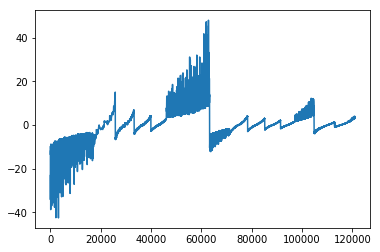

In [44]:
plt.plot(hits_noise['lambda'])

In [45]:
hits1 = hits[hits.particle_id != 0]

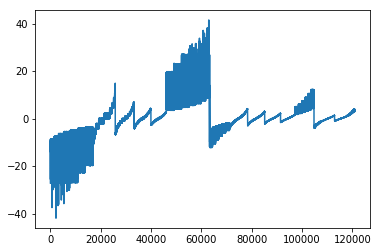

In [46]:
plt.plot(hits1['lambda'])